### Imports

In [34]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa         #library for analyzing audio and music
import librosa.display
from IPython.display import Audio
import IPython.display
from scipy.fftpack import fft
import scipy
from sklearn.model_selection import train_test_split
import tensorflow as tf
%matplotlib inline

# 1. Download the Dataset and Understand the Format

In [4]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# google_drive = GoogleDrive(gauth)
# downloaded = google_drive.CreateFile({'id':"1v4zSFOdfbFyMFalPVB95M0atJDryKRYb"})
# downloaded.GetContentFile('Crema.zip')        
# !unzip -qq /content/Crema.zip -d /content/dataset

In [5]:
path = "/content/dataset/Crema/"
crema_directory = os.listdir(path)

In [6]:
emotions = []
file_path = []

In [7]:
for file in crema_directory:
  file_path.append(path + file)
  emotion = file.split('_')
  if emotion[2] == 'SAD':
      emotions.append('sad')
  elif emotion[2] == 'ANG':
      emotions.append('angry')
  elif emotion[2] == 'DIS':
      emotions.append('disgust')
  elif emotion[2] == 'FEA':
      emotions.append('fear')
  elif emotion[2] == 'HAP':
      emotions.append('happy')
  elif emotion[2] == 'NEU':
      emotions.append('neutral')
  else:
      emotions.append('unknown emotion')

In [8]:
Emotions_df = pd.DataFrame(emotions, columns=['Emotion'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([path_df, Emotions_df], axis=1)
Crema_df.head()

,Path,Emotion
0,/content/dataset/Crema/1089_IWL_ANG_XX.wav,angry
1,/content/dataset/Crema/1050_IOM_DIS_XX.wav,disgust
2,/content/dataset/Crema/1090_IEO_ANG_HI.wav,angry
3,/content/dataset/Crema/1090_TIE_SAD_XX.wav,sad
4,/content/dataset/Crema/1068_IWW_HAP_XX.wav,happy


In [9]:
Crema_df.shape

(7442, 2)

In [10]:
def plot_waveform(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 5))
    plt.title('Waveplot for {} emotion'.format(emotion.upper()), size=15)
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.show()
def spectrogram(data, sampling_rate, emotion):
    X = librosa.stft(data)                      # stft function converts the data into short term fourier transform, we're working in frequency domain
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 5))
    plt.title('Spectrogram for  {} emotion'.format(emotion.upper()), size=15)
    p=librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')   
    plt.colorbar()
    return p
def load_audio(path):
  data, sampling_rate = librosa.load(path)
  plot_waveform(data, sampling_rate, emotion)
  p=spectrogram(data, sampling_rate, emotion)
  print(f'Sampling rate: {sampling_rate}')
  IPython.display.display(Audio(path))
  return p   

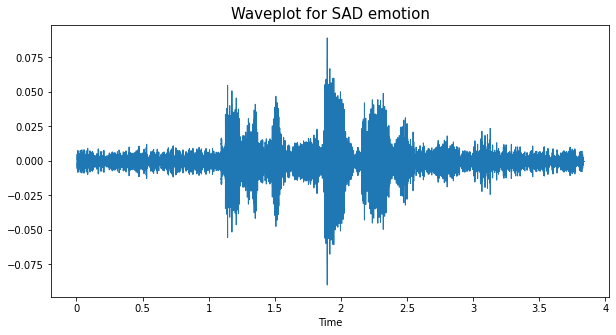

Sampling rate: 22050


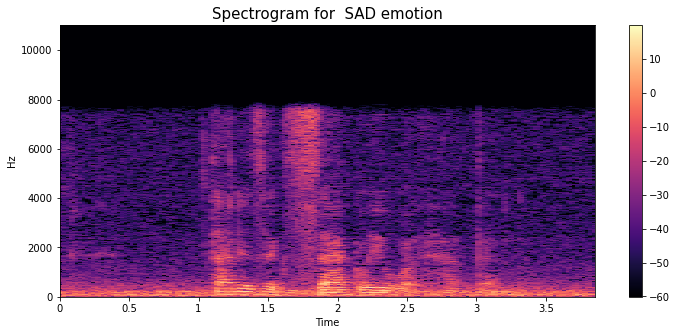

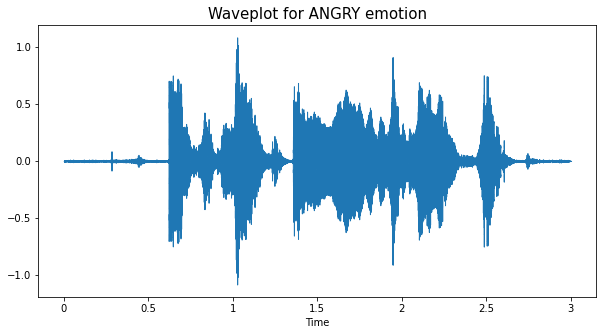

Sampling rate: 22050


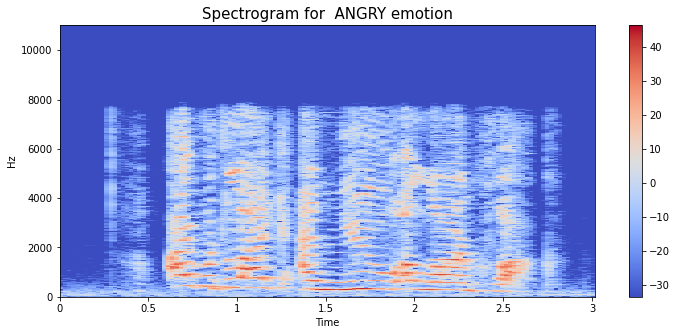

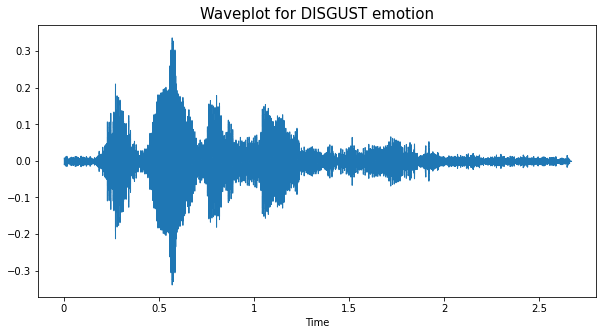

Sampling rate: 22050


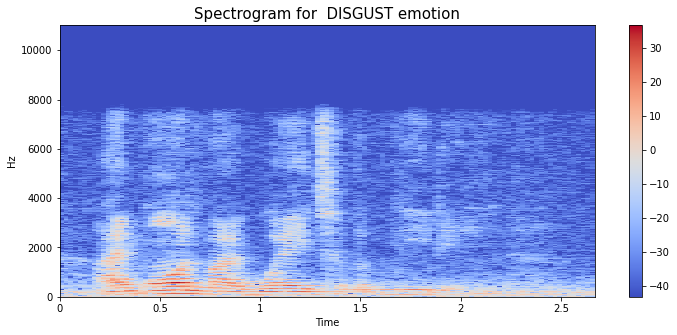

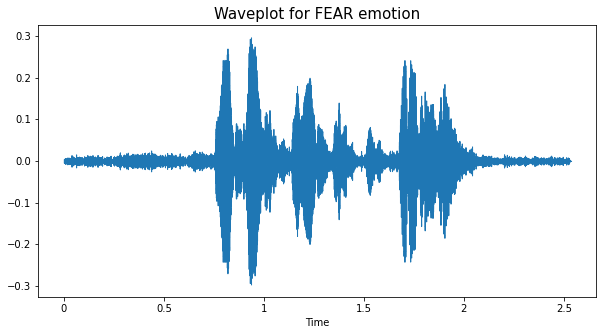

Sampling rate: 22050


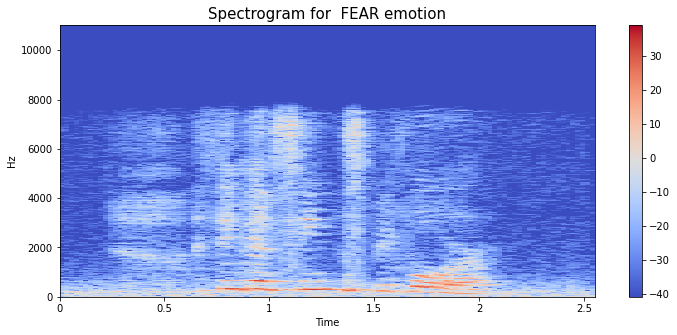

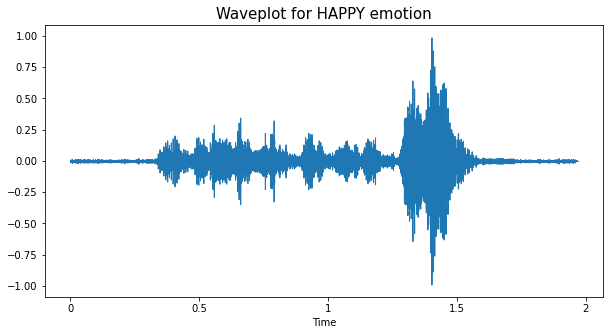

Sampling rate: 22050


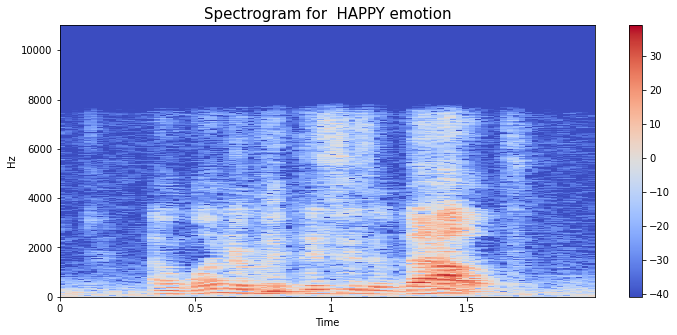

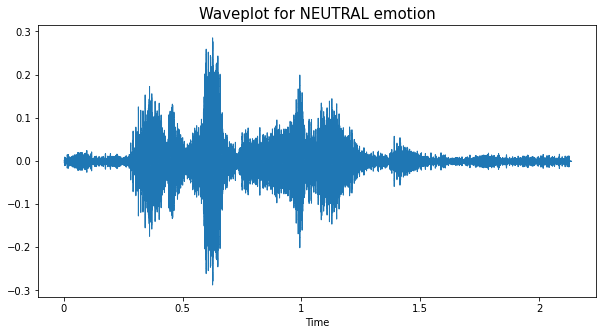

Sampling rate: 22050


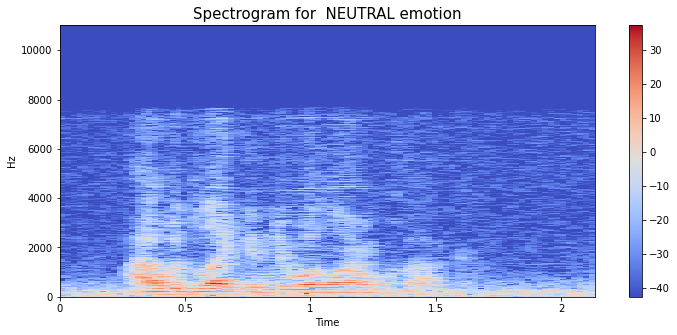

In [11]:
emotions = ['sad', 'angry', 'disgust', 'fear', 'happy', 'neutral']
for emotion in emotions:
  path = np.array(Crema_df.Path[Crema_df.Emotion==emotion])[0]
  p=load_audio(path)
  print(p)

# 2. Create the Feature Space

In [29]:
def aduio_feature(df, feature_fn):
  features = []
  labels = []
  max_shape = (1, 1)
  for index, row in df.iterrows():
    sample, sr = librosa.load(row['Path'], sr=None)
    features.append(feature_fn(sample,))
    labels.append(row['Emotion'])
    if max_shape < features[index].shape:
      max_shape  = features[index].shape

  # Add padding to the audio feature
  for i in range(len(features)):
    padded_array = np.zeros(max_shape)
    shape = np.shape(features[i])
    padded_array[:shape[0],:shape[1]] = features[i]
    features[i] = padded_array

  return np.array(features), np.array(labels)

#### A - work on time domain or frequency domain

In [30]:
rms_features, labels = aduio_feature(Crema_df, librosa.feature.rms)

In [31]:
print(rms_features.shape)
print(labels.shape)

(7442, 1, 157)
(7442,)


In [32]:
zcr_features, labels = aduio_feature(Crema_df, librosa.feature.zero_crossing_rate)

In [33]:
print(zcr_features.shape)
print(labels.shape)

(7442, 1, 157)
(7442,)


#### B - Convert the audio waveform to mel spectrogram

In [41]:
spectrogram_features, labels = aduio_feature(Crema_df, librosa.feature.melspectrogram)

In [42]:
print(spectrogram_features.shape)
print(labels.shape)

(7442, 128, 157)
(7442,)


# 3. Building the Model

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)

In [35]:
rms_X_train_val, rms_X_test, y_train_val, y_test = train_test_split(rms_features, labels, test_size=0.30, random_state=42)
rms_X_train, rms_X_val, y_train, y_val = train_test_split(rms_X_train_val, y_train_val, test_size=0.05, random_state=42)


In [37]:
print(rms_X_train.shape)
print(rms_X_test.shape)
print(rms_X_val.shape)

(4948, 1, 157)
(2233, 1, 157)
(261, 1, 157)


In [38]:
zcr_X_train_val, zcr_X_test, y_train_val, y_test = train_test_split(zcr_features, labels, test_size=0.30, random_state=42)
zcr_X_train, zcr_X_val, y_train, y_val = train_test_split(zcr_X_train_val, y_train_val, test_size=0.05, random_state=42)

In [39]:
print(zcr_X_train.shape)
print(zcr_X_test.shape)
print(zcr_X_val.shape)

(4948, 1, 157)
(2233, 1, 157)
(261, 1, 157)


In [43]:
spectrogram_X_train_val, spectrogram_X_test, y_train_val, y_test = train_test_split(spectrogram_features, labels, test_size=0.30, random_state=42)
spectrogram_X_train, spectrogram_X_val, y_train, y_val = train_test_split(spectrogram_X_train_val, y_train_val, test_size=0.05, random_state=42)

In [44]:
print(spectrogram_X_train.shape)
print(spectrogram_X_test.shape)
print(spectrogram_X_val.shape)

(4948, 128, 157)
(2233, 128, 157)
(261, 128, 157)


# 4. Big Picture